In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

In [3]:
colab_flag = False

FTYPE = np.float32
ITYPE = np.int32

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if gpus:
        gpu_to_use = 0
        tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
        logical_devices = tf.config.list_logical_devices('GPU')
        print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-01-09 16:21:36.948908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 16:21:36.949137: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 16:21:36.986870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 16:21:36.987111: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-09 16:21:36.987397: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [9]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS, readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v5 import Autoencoder
from tools.CrossAttentionRNN_AR_v2 import AR_RNN_CrossAttentionSimpleRNN as RNN_GRU

In [10]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [11]:
# setting up params (and saving, if applicable)
from numpy import *

# RNN directory
dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_046'

# reading AE directory
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]
dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx

try:
    use_ae_data = params_dict['use_ae_data']
except:
    print("'use_ae_data' not present in sim_data_AE_params, set to None.")
    use_ae_data = None

# reading RNN paramaters
with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
    lines = f.readlines()

params_rnn_dict = eval(''.join(lines))

dt_rnn = params_rnn_dict['dt_rnn']
T_sample_input = params_rnn_dict['T_sample_input']
T_sample_output = params_rnn_dict['T_sample_output']
T_offset = params_rnn_dict['T_offset']
return_params_arr = params_rnn_dict['return_params_arr']
params = params_rnn_dict['params']
try:
    normalize_dataset = params_rnn_dict['normalize_dataset']
except:
    print("'normalize_dataset' not present in RNN_specific_data, set to False.")
    normalize_dataset = False
if use_ae_data == None:
    try:
        use_ae_data = params_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in RNN_specific_data, set to True.")
        use_ae_data = True
try:
    normalization_type = params_rnn_dict['normalization_type']
except:
    print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
    normalization_type = 'stddev'
try:
    dense_layer_act_func = params_rnn_dict['dense_layer_act_func']
except:
    print("'dense_layer_act_func' not present in RNN_specific_data, set to 'linear'.")
    dense_layer_act_func = 'linear'

normalization_arr_rnn = None
if normalize_dataset == True:
    with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
        lines = f.readlines()
    normarr_rnn_dict = eval(''.join(lines))
    normalization_arr_rnn = normarr_rnn_dict['normalization_arr']
    
    if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
        with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
            normalization_arr_rnn = fl['normalization_arr'][0]
    
# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in ae_data, set to 'True'.")
    ae_data_with_params = True

print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state_mat = params_dict['init_state_mat']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']
    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

# training params
with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
    lines = f.readlines()

tparams_dict = eval(''.join(lines))

# learning_rate_dict = tparams_dict['learning_rate_dict']
epochs = tparams_dict['epochs']
patience = tparams_dict['patience']
min_delta = tparams_dict['min_delta']
prng_seed = tparams_dict['prng_seed']
train_split = tparams_dict['train_split']
val_split = tparams_dict['val_split']
batch_size = tparams_dict['batch_size']
try:
    learning_rate_dict = tparams_dict['learning_rate_dict']
    lr_begin = learning_rate_dict['eta_begin']
except:
    learning_rate_dict = None
try:
    learning_rate_list = tparams_dict['learning_rate_list']
    lr_begin = learning_rate_list[0]
except:
    learning_rate_list = None

test_split = 1 - train_split - val_split

# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

# set which data to use for plotting histogram
data_to_consider = 'testing' # could be 'all', 'testing', 'training', 'val'

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_046
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_046
data_dir_idx: 005
normalize_flag_ogdata: False


In [12]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [13]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

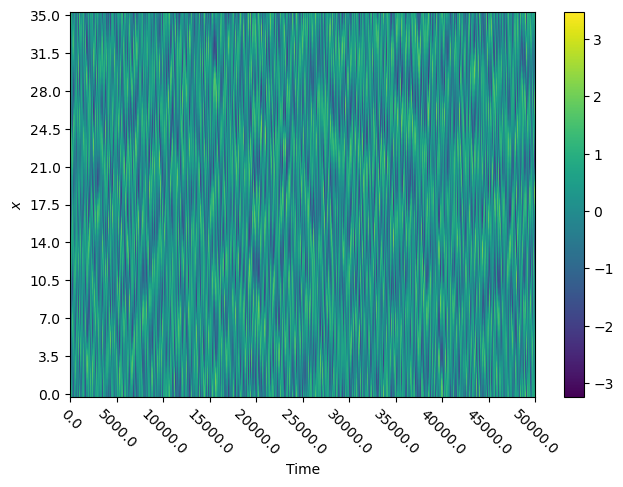

In [14]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [15]:
# dealing with normalizing the data before feeding into autoencoder
if use_ae_data == True:
    if normalizeforae_flag == True:
        for i in range(numpoints_xgrid):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]

    if ae_data_with_params == False:
        all_data = all_data[:, 0:numpoints_xgrid]
else:
    # using raw data, neglecting the params attached (if any)
    all_data = all_data[:, 0:numpoints_xgrid]

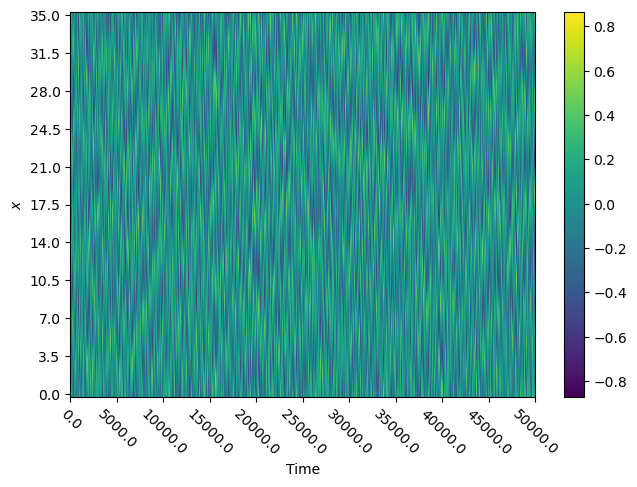

In [16]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

# Autoencoder

In [17]:
# load_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_class_dict.txt'
# wt_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_ae_weights.h5'
if use_ae_data == True:
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [18]:
if use_ae_data == True:
    ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

In [19]:
# create data
if use_ae_data == True:
    latent_states_all = ae_net.encoder_net.predict(all_data)
    del(all_data)
else:
    latent_states_all = all_data[:, 0:xgrid.shape[0]]
num_latent_states = latent_states_all.shape[1]

time_stddev_AEproducedlatentstates = np.std(latent_states_all, axis=0)

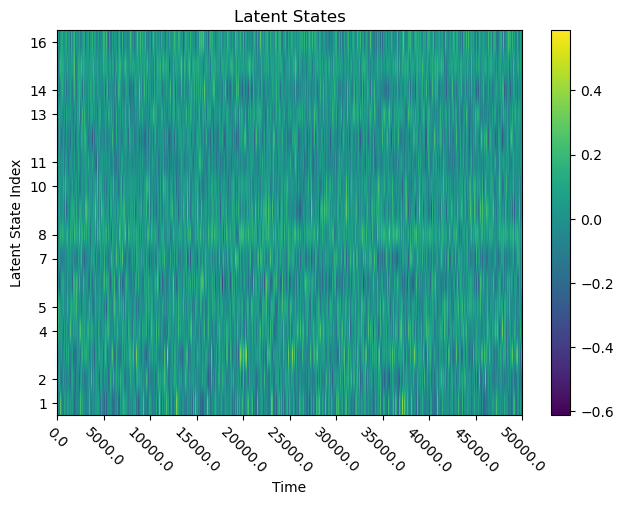

In [20]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=int(40*np.round((T//10)/40)),
    num_yticks=11,
    save_figs=False)

In [21]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# GRU

In [22]:
T_sample_input = np.mean(lyapunov_time_arr)#50.1*dt_rnn
T_sample_output = 2*np.mean(lyapunov_time_arr)
T_offset = T_sample_input

In [23]:
skip_intermediate = 1/4

In [24]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    normalization_arr_external=normalization_arr_rnn,
    return_OrgDataIdxArr=False,
    normalization_type=normalization_type,
    skip_intermediate=skip_intermediate,
)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [25]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev_RNNnormalizeddata = np.std(temp, axis=0)
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [26]:
if data_to_consider != 'all':
    cum_samples = rnn_data_boundary_idx_arr[-1]
    num_train = 0
    num_val = 0
    begin_idx = 0
    for i in range(len(boundary_idx_arr)):
        num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
        num_train += int( (1-test_split-val_split)*num_samples )
        num_val += int(val_split*num_samples)
        begin_idx = rnn_data_boundary_idx_arr[i]

    # defining shapes
    training_input_shape = [num_train]
    training_input_shape.extend(data_rnn_input.shape[1:])

    training_output_shape = [num_train]
    training_output_shape.extend(data_rnn_output.shape[1:])

    val_input_shape = [num_val]
    val_input_shape.extend(data_rnn_input.shape[1:])

    val_output_shape = [num_train]
    val_output_shape.extend(data_rnn_output.shape[1:])

    testing_input_shape = [cum_samples-num_train-num_val]
    testing_input_shape.extend(data_rnn_input.shape[1:])

    testing_output_shape = [cum_samples-num_train-num_val]
    testing_output_shape.extend(data_rnn_output.shape[1:])

    shape_to_use = eval(data_to_consider+'_input_shape')
    rnn_data_idx = np.empty(shape=shape_to_use[0], dtype=np.int32)
    
    begin_idx = 0
    training_data_rolling_count = 0
    val_data_rolling_count = 0
    testing_data_rolling_count = 0
    for i in range(len(boundary_idx_arr)):
        num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
        num_train = int( (1-test_split-val_split)*num_samples )
        num_val = int(val_split*num_samples)
        num_test = num_samples-num_train-num_val+1

        if data_to_consider == 'training':
            rnn_data_idx[training_data_rolling_count:training_data_rolling_count+num_train] = np.arange(begin_idx, begin_idx+num_train)
        elif data_to_consider == 'val':
            rnn_data_idx[val_data_rolling_count:val_data_rolling_count+num_val] = np.arange(begin_idx+num_train, begin_idx+num_train+num_val)
        elif data_to_consider == 'testing':
            rnn_data_idx[testing_data_rolling_count:testing_data_rolling_count+num_test] = np.arange(begin_idx+num_train+num_val, rnn_data_boundary_idx_arr[i])

        training_data_rolling_count += num_train
        val_data_rolling_count += num_val
        testing_data_rolling_count += num_test

        begin_idx = rnn_data_boundary_idx_arr[i]

    # shuffling
    np.random.shuffle(rnn_data_idx)
    data_rnn_input = data_rnn_input[rnn_data_idx]
    data_rnn_output = data_rnn_output[rnn_data_idx]
    del(rnn_data_idx)

In [27]:
# del(data_rnn_input)
# del(data_rnn_output)

In [28]:
print(' data_rnn_input.shape :', data_rnn_input.shape)
print('data_rnn_output.shape :', data_rnn_output.shape)

 data_rnn_input.shape : (432, 77, 16)
data_rnn_output.shape : (432, 155, 16)


In [29]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [31]:
# Initialize network
load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
rnn_net = RNN_GRU(
    load_file=load_file,
    T_input=T_sample_input,
    T_output=T_sample_output,
#     normalization_arr=normalization_arr,
    stddev=0.0,
    stateful=False,
)
rnn_net.build(input_shape=(1, data_rnn_input.shape[1], data_rnn_input.shape[2]))

# wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'final_net_gru_weights.h5'
wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'final_net_crossattentioncell_weights.h5'
# wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'f2'#+dir_sep+'saved_model.pb'

# this forces the model to initialize its kernel weights/biases
# temp = rnn_net.predict(tf.ones(shape=[1, data_rnn_input.shape[1], data_rnn_input.shape[2]]), batch_size=1)
# this loads just the kernel wieghts and biases of the model
rnn_net.load_weights_from_file(wt_file)

# rnn_net = tf.keras.models.load_model(wt_file)

In [32]:
with open(dir_name_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
    lines = f.readlines()

losses_dict = eval(''.join(lines))

val_loss_hist = losses_dict['val_loss_hist']
train_loss_hist = losses_dict['train_loss_hist']
lr_change = losses_dict['lr_change']
# test_loss = losses_dict['test_loss']

In [33]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=losses.MeanSquaredError(),
    run_eagerly=False
)

In [34]:
# %pdb

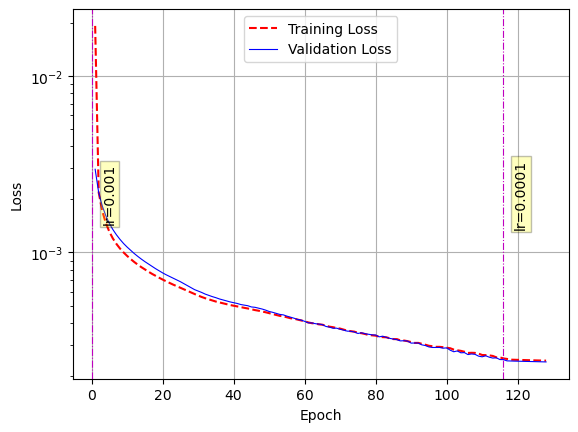

In [35]:
# plotting losses

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

# plt.savefig(dir_name_rnn+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


In [36]:
def rescale_data(data, normalization_arr):
    '''
    data - [num_batches x num_timesteps x num_states]
    normalization_arr = [2 x num_states]
    '''
    new_data = data.copy()
    shape = new_data.shape
    for i in range(data.shape[-1]):
        new_data[:, i] -= normalization_arr[0, i]
        new_data[:, i] /= normalization_arr[1, i]

    return new_data

def norm_sq_time_average(data):
    data_norm_sq = np.zeros(shape=data.shape[0])
    for i in range(data.shape[1]):
        data_norm_sq[:] += data[:, i]**2
    # integrating using the trapezoidal rule
    norm_sq_time_avg = np.sum(data_norm_sq) - 0.5*(data_norm_sq[0]+data_norm_sq[-1])
    norm_sq_time_avg /= data_norm_sq.shape[0]
    return norm_sq_time_avg

def invert_normalization(data, normalization_arr):
    new_data = data.copy()
    shape = new_data.shape
    for i in range(shape[-1]):
        if len(shape) == 2:
            new_data[:, i] *= normalization_arr[1, i]
            new_data[:, i] += normalization_arr[0, i]
        elif len(shape) == 3:
            new_data[:, :, i] *= normalization_arr[1, i]
            new_data[:, :, i] += normalization_arr[0, i]
    return new_data

data_to_consider :  testing
case 1, data_idx : 70


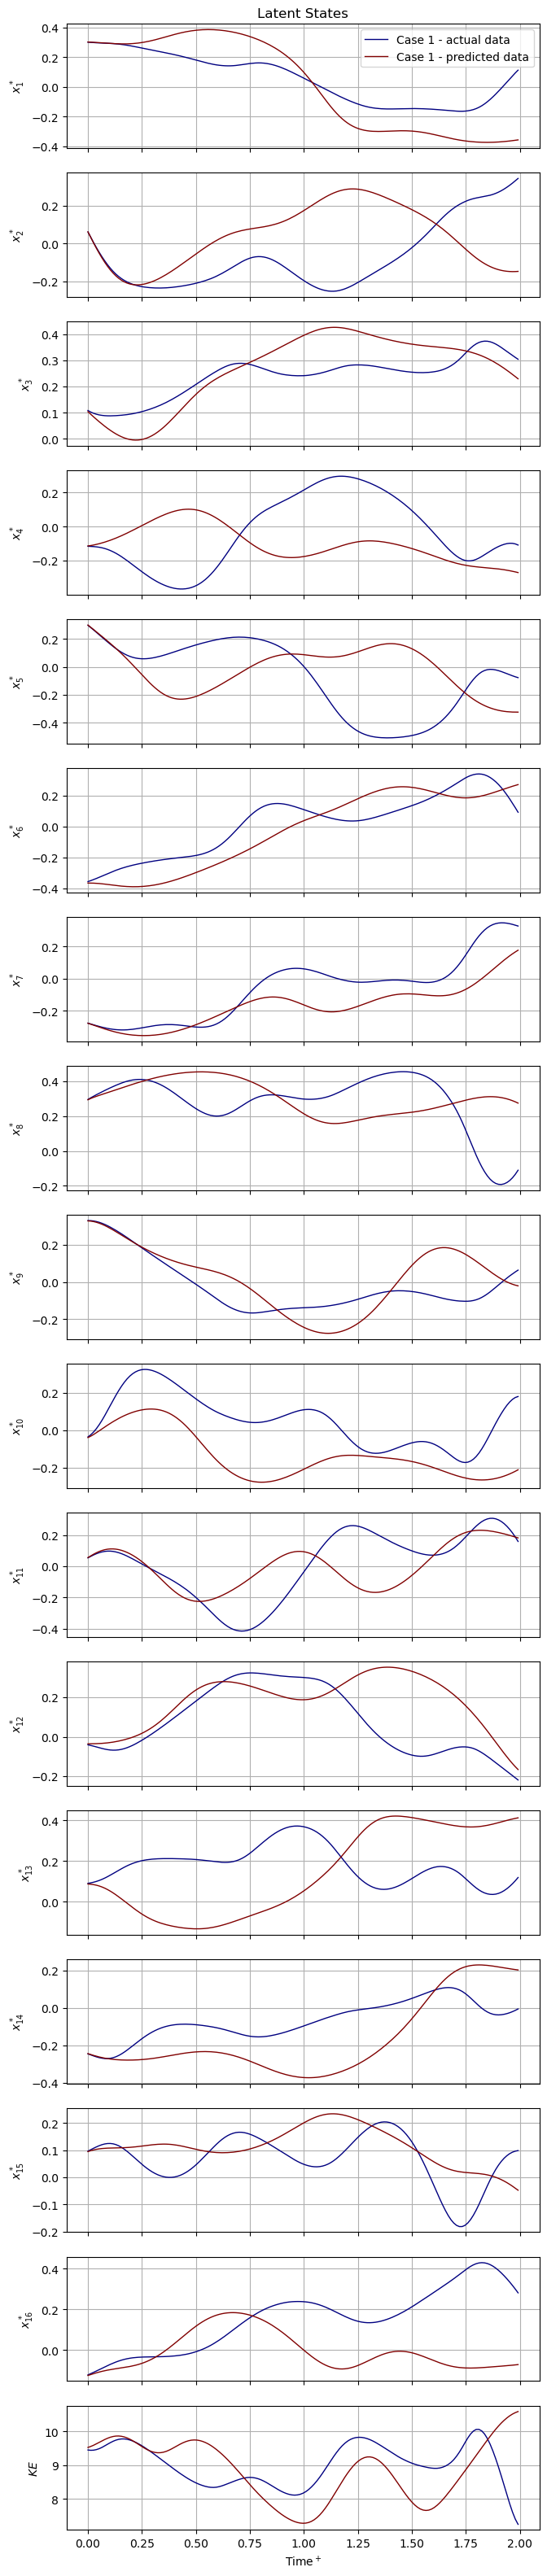


0.18103876333798508


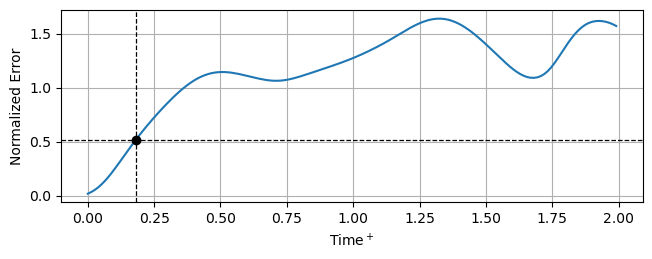

In [37]:
print('data_to_consider : ', data_to_consider)

data_in = data_rnn_input
data_out = data_rnn_output

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 11269
for i in range(len(rnn_data_boundary_idx_arr)):
    if data_idx < rnn_data_boundary_idx_arr[i]:
        case_idx = i
        break
lyap_time = lyapunov_time_arr[case_idx]

print('case {}, data_idx : {}'.format(case_idx+1, data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]
# data_out = rescale_data(data_out, normalization_arr)
data_out = invert_normalization(data_out, normalization_arr)

# prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :], batch_size=1)
prediction = rnn_net(data_in[data_idx:data_idx+1, :, :], training=False).numpy()
# prediction = rnn_net.call(data_in[data_idx:data_idx+1, :, :], training=False)
prediction = invert_normalization(prediction, normalization_arr)

#-- computing KE --#
KE_og = ae_net.decoder_net.predict(data_out)
KE_pred = ae_net.decoder_net.predict(prediction[0, :, :])

KE_og = np.sum(KE_og**2, axis=1)
KE_pred = np.sum(KE_pred**2, axis=1)
#-- KE computed --#

n = 1
num_latent_states = data_out.shape[-1]
N = data_out.shape[0]

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = ['$x^*_{' +str(i)+'}$' for i in range(1, num_latent_states+1)]

fig, ax = plt.subplots(num_latent_states+1, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]
input_time = np.arange(0, N)*dt_rnn/lyap_time

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

mpl_ax_artist_list = []
for j in range(num_latent_states):
    for i in range(n):
        obj_in = ax[j].plot(input_time, data_out[:, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        obj_out = ax[j].plot(input_time, prediction[0, :, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
        mpl_ax_artist_list.append(obj_in[0])
        mpl_ax_artist_list.append(obj_out[0])
    ax[j].set_ylabel(ax_ylabels[j])
    # if xlim is not None:
    #     ax[j].set_xlim(xlim)
    # if ylim is not None:
    #     ax[j].set_ylim(ylim)
    ax[j].grid(True)
    ax[j].set_axisbelow(True)

ax[-1].plot(input_time, KE_og, linewidth=1, color=colors[0], label='Case {} - actual KE'.format(i+1))
ax[-1].plot(input_time, KE_pred, linewidth=1, color=colors[1], label='Case {} - predicted KE'.format(i+1))
ax[-1].set_ylabel('$KE$')
ax[-1].grid(True)
ax[-1].set_axisbelow(True)

ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)
plt.show()
# plt.savefig('AR-GRU.png', dpi=300, bbox_inches='tight')
print('')

### Error and prediction horizon
# error = np.linalg.norm(data_out[:, :] - prediction[0, :, :], axis=1)
error = (data_out[:, :] - prediction[0, :, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev_AEproducedlatentstates**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0][0]
# predhor_idx = np.where(error <= error_threshold)[0]

ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)

plt.show()

In [38]:
data_in.shape

(432, 77, 16)

In [39]:
data_in_og = data_rnn_input
data_out_og = data_rnn_output

num_runs = 100
num_runs = np.min([num_runs, data_in_og.shape[0]])
print('num_runs :', num_runs)
error_threshold = 0.5

# data_idx_arr = np.arange(data_in_og.shape[0])
# np.random.shuffle(data_idx_arr)
data_idx_arr = np.linspace(0, data_in_og.shape[0]-1, num_runs, dtype=np.int32)

prediction_horizon_arr = np.empty(shape=num_runs)

# prediction = rnn_net.predict(data_in_og[data_idx_arr[0:num_runs], :, :])
prediction = rnn_net(data_in_og[data_idx_arr[0:num_runs], :, :], training=False).numpy()
prediction = invert_normalization(prediction, normalization_arr)

for i in range(num_runs):
    data_idx = data_idx_arr[i]

    for j in range(len(rnn_data_boundary_idx_arr)):
        if data_idx < rnn_data_boundary_idx_arr[j]:
            case_idx = j
            break
    lyap_time = lyapunov_time_arr[j]
    
    data_out = data_out_og[data_idx]
#     data_out = rescale_data(data_out, normalization_arr)
    data_out = invert_normalization(data_out, normalization_arr)

    # prediction = rnn_net.predict(data_in_og[data_idx:data_idx+1, :, :])

    ### Error and prediction horizon
    # error = np.linalg.norm(data_out[:, :] - prediction[i, :, :], axis=1)
    error = (data_out[:, :] - prediction[i, :, :])**2
    # error /= norm_sq_time_average(data_out)**0.5
    error = np.mean(np.divide(error, time_stddev_AEproducedlatentstates**2), axis=1)**0.5

    predhor_idx = np.where(error >= error_threshold)[0]
    if predhor_idx.shape[0] == 0:
        predhor_idx = error.shape[0]
    else:
        predhor_idx = predhor_idx[0]

    prediction_horizon_arr[i] = predhor_idx*dt_rnn/lyap_time

median_idx = int(np.round(0.5*num_runs-1))
quartile_1_idx = int(np.round(0.25*num_runs-1))
quartile_3_idx = int(np.round(0.75*num_runs-1))

prediction_horizon_arr.sort()

median = prediction_horizon_arr[median_idx]
quartile_1 = prediction_horizon_arr[quartile_1_idx]
quartile_3 = prediction_horizon_arr[quartile_3_idx]
IQR = quartile_3 - quartile_1

prediction_horizon = np.mean(prediction_horizon_arr)
stddev_ph = np.std(prediction_horizon_arr)

s = 'error_threshold = {}\n'.format(error_threshold)
s += 'prediction_horizon : {}, median : {}\n'.format(prediction_horizon, median)
s += 'ph_min : {}, ph_max : {}\n'.format(prediction_horizon_arr.min(), prediction_horizon_arr.max())
s += 'stddev : {}, IQR : {}\n'.format(stddev_ph, IQR)
s += '1st quartile : {}, 3rd quartile : {}'.format(quartile_1, quartile_3)

print(dir_name_rnn[-7:])
print('\n'+s)

num_runs : 100
rnn_046

error_threshold = 0.5
prediction_horizon : 0.2396177346180617, median : 0.2327641242916951
ph_min : 0.10345072190742005, ph_max : 0.34914618643754264
stddev : 0.055693557500938094, IQR : 0.09051938166899254
1st quartile : 0.1939701035764126, 3rd quartile : 0.2844894852454051


In [40]:
savefig_fname = 'pre-ARtraining'+'_'+data_to_consider+'data'
# savefig_fname = 'post-ARtraining'
# savefig_fname = None
# nbins = np.min([100, data_in.shape[0]//8])

In [41]:
if savefig_fname != None:
    npsavedata_fname = '/prediction_horizons-'+data_to_consider+'data'
    np.savez(
        dir_name_rnn+npsavedata_fname,
        prediction_horizon_arr=prediction_horizon_arr,
        error_threshold=error_threshold,
    )
    
    with open(dir_name_rnn+npsavedata_fname+'-statistics.txt', 'w') as fl:
        fl.write(s)

In [42]:
fig, ax = plt.subplots()

bin_width = 0.05
bin_begin = 0
bin_end = bin_width*np.round((np.max(prediction_horizon_arr)+0.5*bin_width)//bin_width)
nbins = int(np.round(bin_end/bin_width))

ax.hist(prediction_horizon_arr, bins=nbins, range = [bin_begin, bin_end], density=True)
ax.axvline(prediction_horizon, linewidth=0.9, linestyle='--', color='k')

ax.set_xlabel('Prediction Horizon (Lyapunov times)')
ax.set_ylabel('PDF')

ax.grid(True)
# ax.set_axisbelow(True)

ax.text(
    0.01 + ax.transAxes.inverted().transform(ax.transData.transform([prediction_horizon, 0]))[0],
    0.8,
    'mean',
    rotation=90,
    verticalalignment='bottom',
    horizontalalignment='left',
    bbox=dict(facecolor=np.array([255,255,153])/255, alpha=1, boxstyle='square,pad=0.2'),
    transform=ax.transAxes
)

text_xy = [0.95, 0.95]
ax.text(
    text_xy[0],
    text_xy[1],
    'mean : {:.4f}\nmax : {:.4f}\nmin : {:.4f}\nstddev : {:.4f}'.format(
        prediction_horizon,
        np.max(prediction_horizon_arr),
        np.min(prediction_horizon_arr),
        stddev_ph,
    ),
    transform=ax.transAxes,
    bbox=dict(
        boxstyle="round",
        ec=(0.6, 0.6, 1),
        fc=(0.9, 0.9, 1),
    ),
    # bbox=dict(facecolor='C0', alpha=0.5, boxstyle='round,pad=0.2'),
    horizontalalignment='right',
    verticalalignment='top'
)

ax.set_title('nbins = {}'.format(nbins))

if savefig_fname is not None:
    fig.savefig(dir_name_rnn+dir_sep+'plots'+dir_sep+savefig_fname+'.png', dpi=300, bbox_inches='tight')
    fig.clear()
    plt.close()
else:
    plt.show()
    print('')